In [38]:
%load_ext autoreload
%autoreload 2

from darts.datasets import ETTh1Dataset, WineDataset
# from darts.models import NLinearModel
from darts.metrics.metrics import mae, mse
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.nn.functional import binary_cross_entropy_with_logits, cross_entropy, mse_loss, cosine_similarity
import random
import csv
import datetime
import os
import gc
from time import sleep
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import LambdaLR
from torchmetrics.regression import MeanAbsoluteError, MeanSquaredError
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

import optuna
from optuna.trial import TrialState
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_timeline

import models.models_original as models_original
import models.models_3d_atomics as new_models
from vasopressor.preprocess_helpers import *
from models.helper import *
from models.param_initializations import *
from models.optimization_strategy import greedy_forward_selection

device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
device

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


device(type='cuda')

176

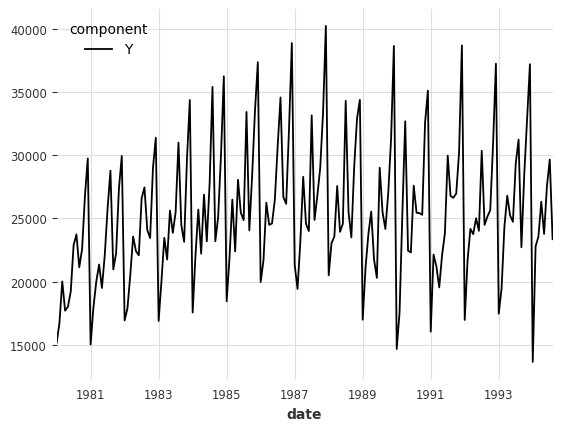

In [39]:
wine_series = WineDataset().load().pd_dataframe()
wine_series.plot()
len(wine_series)

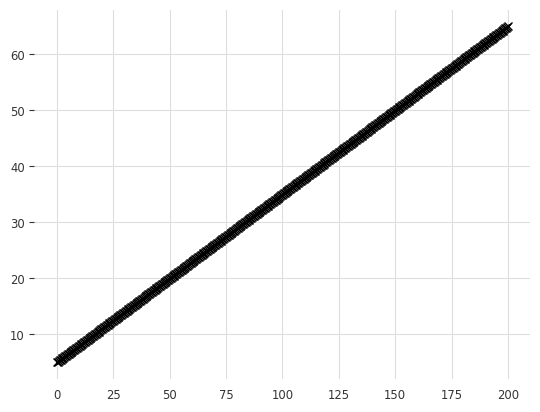

In [40]:

def line(x, w=0.3, b=5):
    return w*x + b

time = np.linspace(0, 200, 500).reshape(-1,1)

trend_series = line(time)
trend_series = np.array(trend_series).reshape(-1,1)

plt.plot(time, trend_series, marker="x")
plt.show()

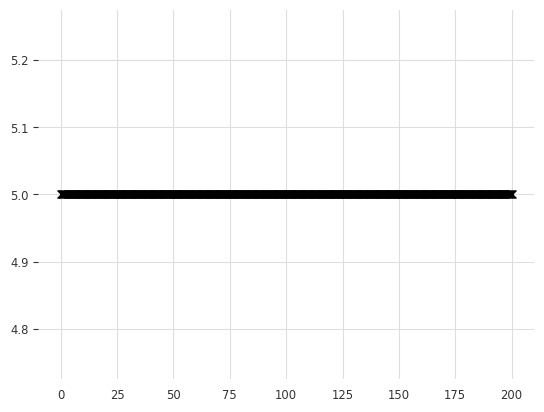

In [41]:

flat_series = line(time, w=0)
flat_series = np.array(flat_series).reshape(-1,1)

plt.plot(time, flat_series, marker="x")
plt.show()

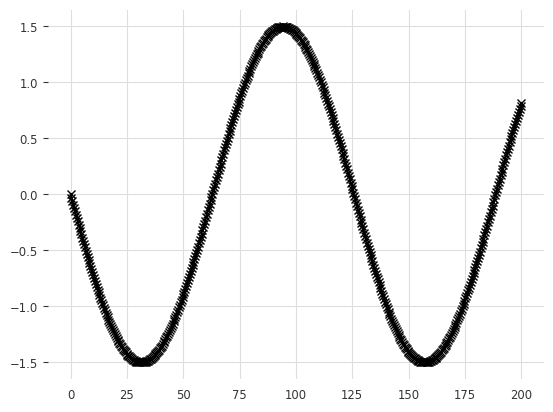

In [42]:

def sine_wave(time, frequency = 1, amplitude = 1, phase = 0):
    return amplitude * np.sin(frequency * time + phase)

sine_series = sine_wave(time, frequency = 0.05, amplitude = 1.5, phase = np.pi)

plt.plot(time, sine_series, marker="x")
plt.show()

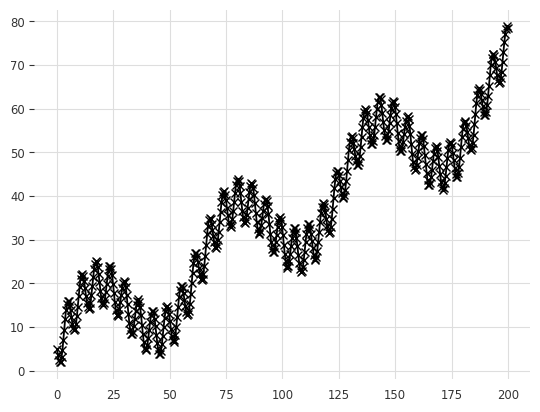

In [43]:

components_series = sine_wave(time, frequency = 1, amplitude = 5, phase = np.pi) \
                + sine_wave(time, frequency = 0.1, amplitude = 10, phase = 0) \
                + trend_series

plt.plot(time[:3000], components_series[:3000], marker="x")
plt.show()

In [44]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, targets, T, window_stride=1, pred_len=1):
        self.data = data
        self.targets = targets
        assert targets.size(0) == data.size(0)
        self.T = T # time window
        self.window_stride = window_stride
        self.pred_len = pred_len
        self.N, self.V = data.shape

    def __len__(self):
        return len(range(0, self.N - self.T - self.pred_len + 1, self.window_stride))

    def __getitem__(self, idx):
        start = idx * self.window_stride
        end = start + self.T

        X = self.data[start:end].flatten()
        # if mode == "S": # predict only target
        y = self.targets[end:end + self.pred_len].flatten()
        # elif mode == "MS": # predict all variables
        #   y = self.data[end:end + self.pred_len, :7].flatten()
        return X, y


In [45]:
def preprocess_data(series, seq_len, window_stride=1, pred_len=1, batch_size = 512):
    scaler = StandardScaler()
    
    train_end = int(len(series) * 0.6)
    val_end = int(train_end + len(series) * 0.2)
    
    train = series[:train_end]
    val = series[train_end:val_end]
    test = series[val_end:]
    
    # train, test = series.split_before(0.6)
    # val, test = test.split_before(0.5)
    
    print("Train/Val/Test", len(train), len(val), len(test))
    
    train = scaler.fit_transform(train)
    X_train = pd.DataFrame(train)
    y_train = X_train
    X_train = torch.tensor(X_train.to_numpy(), dtype=torch.float32)
    y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32)
    
    # indicators = torch.isfinite(X_train)
    # X_train = torch.cat([X_train, indicators], axis=1)
    
    train_dataset = TimeSeriesDataset(X_train, y_train, seq_len, window_stride, pred_len)
    train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=False, num_workers=0, pin_memory=True)

    val = scaler.transform(val)
    X_val = pd.DataFrame(val)
    y_val = X_val
    X_val = torch.tensor(X_val.to_numpy(), dtype=torch.float32)
    y_val = torch.tensor(y_val.to_numpy(), dtype=torch.float32)
    
    # indicators = torch.isfinite(X_val)
    # X_val = torch.cat([X_val, indicators], axis=1)
    
    val_dataset = TimeSeriesDataset(X_val, y_val, seq_len, window_stride, pred_len)
    val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=False, num_workers=0, pin_memory=True)

    test = scaler.transform(test)
    X_test = pd.DataFrame(test)
    y_test = X_test
    X_test = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
    y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32)
    
    # indicators = torch.isfinite(X_test)
    # X_test = torch.cat([X_test, indicators], axis=1)
    
    test_dataset = TimeSeriesDataset(X_test, y_test, seq_len, window_stride, pred_len)
    test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False, num_workers=0, pin_memory=True)
    
    return train_loader, val_loader, test_loader, scaler


Train/Val/Test 300 100 100
torch.Size([276, 20]) False
torch.Size([276, 5]) False


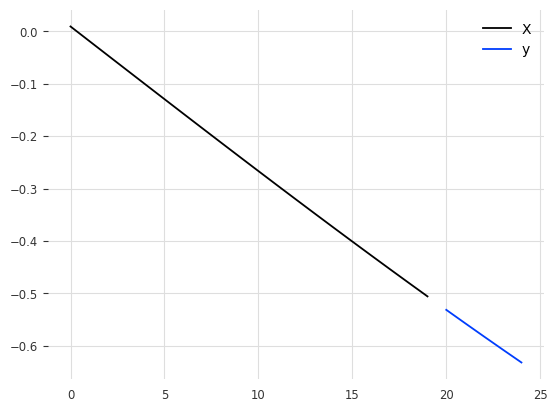

Batches 1 1 1


In [46]:
seq_len = 20
pred_len = 5

train_loader, val_loader, test_loader, scaler = preprocess_data(sine_series, seq_len, pred_len=pred_len)

for X,y in train_loader:
    print(X.shape, X.requires_grad)
    print(y.shape, X.requires_grad)
    break

i = 0
plt.plot(range(seq_len), X[i, :], label="X")
# plt.plot(range(seq_len), X[i, :, 1], label="X IND")
plt.plot(range(seq_len, seq_len + pred_len), y[i], label="y")
plt.legend()
plt.show()


print("Batches", len(train_loader), len(val_loader), len(test_loader))


In [47]:
# plots
def plot_losses(train_losses, val_losses):
    plt.plot(train_losses, color="black", label="Train")
    plt.plot(val_losses, color="green", label="Val")
    plt.yscale("log")
    plt.legend()
    plt.show()

def plot_mae_mse(history, title, dec="{:.3g}"):
    xticks = range(len(history[:, 0]))
    plt.plot(xticks, history[:, 2], label='MAE')
    plt.plot(xticks, history[:, 3], label='MSE')

    plt.xlabel('Num Concepts')
    plt.ylabel('Criteria')
    # plt.ylim(0, 1)
    xtick_labels = list(map(int, history[:, 0]))
    plt.xticks(xticks, xtick_labels)
    plt.yscale('log')

    if dec:
        for x,_y in zip(xticks, history[:, 2]):
            label = dec.format(_y)
            plt.annotate(label, # this is the text
                        (x,_y), # these are the coordinates to position the label
                        textcoords="offset points", # how to position the text
                        xytext=(0,-10), # distance from text to points (x,y)
                        ha='center') # horizontal alignment can be left, right or center
            
        for x,_y in zip(xticks, history[:, 3]):
            label = dec.format(_y)
            plt.annotate(label, # this is the text
                        (x,_y), # these are the coordinates to position the label
                        textcoords="offset points", # how to position the text
                        xytext=(0,-10), # distance from text to points (x,y)
                        ha='center') # horizontal alignment can be left, right or center

    plt.title(title)
    plt.legend()
    plt.show()


def plot_atomics_concepts_metric(history, title, dec="{:.3g}"):
        
    df = pd.DataFrame(history, columns=["n_atomics", "n_concepts", "val_loss", "mae", "mse"])
    mean_atomics = df.groupby("n_atomics").mean()
    mean_concepts = df.groupby("n_concepts").mean()

    # display(mean_atomics)
    plt.plot(mean_atomics.index, mean_atomics["mae"], label='MAE')
    plt.plot(mean_atomics.index, mean_atomics["mse"], label='MSE')
    plt.xlabel('Num Atomics')
    plt.ylabel('Criteria')
    plt.title("Metric as mean over atomics")
    plt.suptitle(title)
    plt.legend()
    plt.show()

    # display(mean_concepts)
    plt.plot(mean_concepts.index, mean_concepts["mae"], label='MAE')
    plt.plot(mean_concepts.index, mean_concepts["mse"], label='MSE')
    plt.xlabel('Num Concepts')
    plt.ylabel('Criteria')
    plt.title("Metric as mean over concepts")
    plt.suptitle(title)
    plt.legend()
    plt.show()
    

def plot_prediction_vs_true(Xb, yb, preds, title):
    x = list(range(len(Xb)))
    xx = list(range(len(Xb), len(Xb)+len(yb)))
    plt.plot(x, Xb, color="black", label="True X")
    plt.plot(xx, yb, color="blue", label="True y")
    plt.plot(xx, preds, color="red", label="Pred y")
    plt.yscale("linear")
    plt.ticklabel_format(useOffset=False, style='plain')
    plt.title(title)
    plt.legend()
    plt.show()


In [48]:

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, device="cuda"):
        super(SimpleNN, self).__init__()
        self.device = device
        
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, output_size)
        
    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x
    
    
    def _load_model(self, path, print_=True):
        """
        Args:
            path (str): filepath to the model
        """
        try:
            checkpoint = torch.load(path)
        except:
            return
        
        self.load_state_dict(checkpoint['model_state_dict'])
        if print_:
            print("Loaded model from " + path)
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.curr_epoch = checkpoint['epoch']
        self.train_losses = checkpoint['train_losses']
        self.val_losses = checkpoint['val_losses']
        
        self.earlyStopping.best_state = checkpoint
        self.earlyStopping.min_max_criterion = min(checkpoint['val_losses'])
        
        sleep(0.5)
        
        return checkpoint.get("early_stopping", False)
    
    def fit(self, train_loader, val_loader, p_weight, save_model_path, max_epochs=10000, save_every_n_epochs=10, patience=10, warmup_epochs=0, scheduler=None, trial=None, show_grad=False):
        """
        
        Args:
            train_loader (torch.DataLoader): 
            val_tensor (torch.DataLoader):
            p_weight (tensor): weight parameter used to calculate BCE loss 
            save_model_path (str): filepath to save the model progress
            epochs (int): number of epochs to train
        """
        
        self.train_losses = []
        self.val_losses = []
        self.curr_epoch = -1
        
        self.earlyStopping = EarlyStopping(patience=patience, warmup_epochs=warmup_epochs)
        early_stopped = self._load_model(save_model_path)
        
        if early_stopped:
            return
        
        epochs = range(self.curr_epoch+1, max_epochs)
        
        with tqdm(total=len(epochs), unit=' epoch') as pbar:
            
            for epoch in epochs:
                self.train()
                train_loss = 0
            
                ### Train loop
                for Xb, yb in train_loader:
                    Xb, yb = Xb.to(self.device), yb.to(self.device)
                    y_pred = self(Xb)

                    loss = mse_loss(yb, y_pred)
                    
                    self.optimizer.zero_grad(set_to_none=True)
                    loss.backward()
                    train_loss += loss * Xb.size(0)
                    
                    
                    self.optimizer.step()
                
                train_loss = train_loss / len(train_loader.sampler)
                
                
                if (epoch % save_every_n_epochs) == 0:
                    self.eval()
                    with torch.no_grad():
                        
                        self.train_losses.append(train_loss.item())
                        
                        ### Validation loop
                        val_loss = 0
                        for Xb, yb in val_loader:
                            Xb, yb = Xb.to(self.device), yb.to(self.device)
                
                            # Forward pass.
                            y_pred = self(Xb)

                            val_loss += mse_loss(yb, y_pred, p_weight) * Xb.size(0)
                        
                        val_loss = val_loss / len(val_loader.sampler)
                        self.val_losses.append(val_loss.item())
                        
                        
                        ### Auxilliary stuff
                        state = create_state_dict(self, epoch)
                        
                        if self.earlyStopping.check_improvement(val_loss, state):
                            break
                        
                        if scheduler:
                            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                                scheduler.step(val_loss)
                            else:
                                scheduler.step()
                        
                        if save_model_path:
                            torch.save(state, save_model_path)
                        
                        if trial:
                            trial.report(val_loss, epoch)
                            
                            if trial.should_prune():
                                raise optuna.exceptions.TrialPruned()
                
                pbar.set_postfix({'Train Loss': f'{train_loss.item():.5f}', 'Val Loss': f'{val_loss:.5f}'})
                pbar.update()
            
        if save_model_path and self.earlyStopping.best_state:
            torch.save(self.earlyStopping.best_state, save_model_path)
        
        return self.val_losses[-1]



from tqdm import tqdm
from EarlyStopping import EarlyStopping

def create_state_dict(model, epoch):
    state = {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': model.optimizer.state_dict(),
                    'train_losses': model.train_losses,
                    'val_losses': model.val_losses,
                    }
        
    return state


In [49]:

def init_model(input_size = 100, hidden_size1 = 100, hidden_size2 = 100, output_size = 10):

    model = SimpleNN(input_size, hidden_size1, hidden_size2, output_size)
    model = model.to(device)

    opt_lr = 1e-3
    # opt_weight_decay = 1e-5
    model.optimizer = torch.optim.Adam(model.parameters(), lr = opt_lr)#, weight_decay = opt_weight_decay)
    
    return model


In [50]:
random_seed = 1
set_seed(random_seed)


In [51]:
seq_len = 20
pred_len = 10
n_atomics_list = list(range(2,11,2))
n_concepts_list = list(range(2,11,2))
changing_dim = 1 #len(series.columns)
input_dim = 2 * changing_dim


## Blaaa

In [40]:
experiment_folder = f"/workdir/optimal-summaries-public/_models/debug/debugging-L{seq_len}-T{pred_len}/"
# model_path_re = experiment_folder + "forecasting_c{}_a{}.pt"
model_path_re = experiment_folder + "forecasting_c{}.pt"

if not os.path.exists(experiment_folder):
    os.makedirs(experiment_folder)

Train/Val/Test 300 100 100


  1%|          | 1060/100000 [01:16<1:58:38, 13.90 epoch/s, Train Loss=0.00009, Val Loss=0.29146]


Early Stopped
MSE 8.99575388757512e-05 MAE 0.006337652914226055


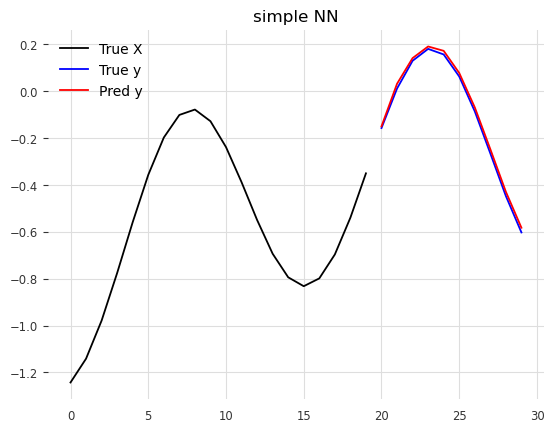

,0
-0.149906,-0.157130
0.031792,0.011372
0.141244,0.129801
0.190848,0.180611
0.172264,0.156743
0.077728,0.062743
-0.068999,-0.085956
-0.247397,-0.265476
-0.429132,-0.447281
-0.582513,-0.602690


MSE 0.5769482254981995 MAE 0.682745635509491


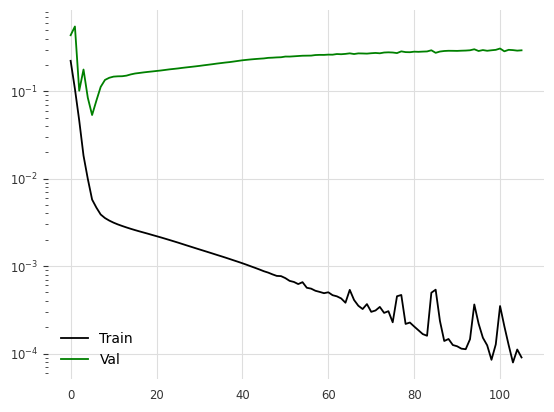

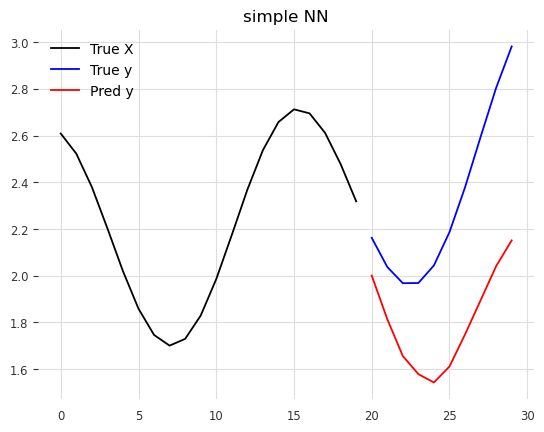

,0
2.000642,2.162266
1.814250,2.037621
1.656394,1.968142
1.578949,1.968957
1.543340,2.044262
1.611868,2.186656
1.748957,2.378304
1.894674,2.593764
2.041044,2.804011
2.151253,2.981035


In [53]:
# Plot Prediction vs actual
train_loader, val_loader, test_loader, scaler = preprocess_data(components_series, seq_len, pred_len=pred_len)

mae_metric = MeanAbsoluteError().to(device)
mse_metric = MeanSquaredError().to(device)


model = init_model(input_size = seq_len, hidden_size1 = 256, hidden_size2 = 256, output_size = pred_len)

scheduler = None # torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=model.optimizer, patience=10, factor=0.7, verbose=True)

model.fit(train_loader, val_loader, None, save_model_path=None, max_epochs=100000, scheduler=scheduler, patience=100)

model.eval()
with torch.no_grad():
    for batch_idx, (Xb, yb) in enumerate(train_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        preds = model(Xb)
        
        mae = mae_metric(preds, yb).item()
        mse = mse_metric(preds, yb).item()
    mae = mae_metric.compute().item()
    mse = mse_metric.compute().item()
    mae_metric.reset()
    mse_metric.reset()

    print("MSE", mse, "MAE", mae)


    for batch_idx, (Xb, yb) in enumerate(train_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        preds = model(Xb)
        break


i = 20
yb = yb.cpu().numpy()[i].reshape(-1, 1)
preds = preds.cpu().numpy()[i].reshape(-1, 1)
Xb = Xb.cpu().numpy()[i].reshape(-1, 1)

plot_prediction_vs_true(Xb, yb, preds, title=f"simple NN")
display(pd.DataFrame(yb.flatten(), preds.flatten()))



model.eval()
with torch.no_grad():
    for batch_idx, (Xb, yb) in enumerate(test_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        preds = model(Xb)
        
        mae = mae_metric(preds, yb).item()
        mse = mse_metric(preds, yb).item()
    mae = mae_metric.compute().item()
    mse = mse_metric.compute().item()
    mae_metric.reset()
    mse_metric.reset()

    print("MSE", mse, "MAE", mae)


    for batch_idx, (Xb, yb) in enumerate(test_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        preds = model(Xb)
        break



plot_losses(model.train_losses[1:], model.val_losses[1:])


i = 0
yb = yb.cpu().numpy()[i].reshape(-1, 1)
preds = preds.cpu().numpy()[i].reshape(-1, 1)
Xb = Xb.cpu().numpy()[i].reshape(-1, 1)

plot_prediction_vs_true(Xb, yb, preds, title=f"simple NN")
display(pd.DataFrame(yb.flatten(), preds.flatten()))


In [15]:
# Plot Prediction vs actual
train_loader, val_loader, test_loader, scaler = preprocess_data(sine_series, seq_len, pred_len=pred_len)

mae_metric = MeanAbsoluteError().to(device)
mse_metric = MeanSquaredError().to(device)



model = init_model(input_size = seq_len, hidden_size1 = seq_len * 100, hidden_size2 = 1000, output_size = pred_len)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=model.optimizer, patience=10, factor=0.7, verbose=True)

model.fit(train_loader, val_loader, None, save_model_path=model_path_re.format("sine_simpleNN"), max_epochs=100000, scheduler=scheduler, patience=100)

plot_losses(model.train_losses, model.val_losses)

model.eval()
with torch.no_grad():
    for batch_idx, (Xb, yb) in enumerate(train_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        preds = model(Xb)
        
        mae = mae_metric(preds, yb).item()
        mse = mse_metric(preds, yb).item()
    mae = mae_metric.compute().item()
    mse = mse_metric.compute().item()
    mae_metric.reset()
    mse_metric.reset()

    print("MSE", mse, "MAE", mae)


    for batch_idx, (Xb, yb) in enumerate(train_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        preds = model(Xb)
        break

i = 20
yb = yb.cpu().numpy()[i].reshape(-1, 1)
preds = preds.cpu().numpy()[i].reshape(-1, 1)
Xb = Xb.cpu().numpy()[i].reshape(-1, 1)

plot_prediction_vs_true(Xb, yb, preds, title=f"simple NN")
display(pd.DataFrame(yb.flatten(), preds.flatten()))


Xbs = scaler.inverse_transform(Xb)
ybs = scaler.inverse_transform(yb)
predss = scaler.inverse_transform(preds)

plot_prediction_vs_true(Xbs, ybs, predss, title=f"simple NN")
display(pd.DataFrame(ybs.flatten(), predss.flatten()))


Train/Val/Test 6000 2000 2000


  0%|          | 340/100000 [01:54<7:59:33,  3.46 epoch/s, Train Loss=69.60911, Val Loss=1.00113]   

Epoch 00035: reducing learning rate of group 0 to 7.0000e-03.


  0%|          | 450/100000 [02:31<8:15:00,  3.35 epoch/s, Train Loss=1.02465, Val Loss=1.03387]   

Epoch 00046: reducing learning rate of group 0 to 4.9000e-03.


  1%|          | 560/100000 [03:08<7:42:34,  3.58 epoch/s, Train Loss=1.01682, Val Loss=1.00247] 

Epoch 00057: reducing learning rate of group 0 to 3.4300e-03.


  1%|          | 1060/100000 [05:58<7:42:10,  3.57 epoch/s, Train Loss=0.00492, Val Loss=0.00405] 

Epoch 00107: reducing learning rate of group 0 to 2.4010e-03.


  1%|          | 1200/100000 [06:45<7:49:50,  3.50 epoch/s, Train Loss=0.00032, Val Loss=0.00018] 

In [ ]:
# Plot Prediction vs actual
train_loader, val_loader, test_loader, scaler = preprocess_data(components_series, seq_len, pred_len=pred_len)

mae_metric = MeanAbsoluteError().to(device)
mse_metric = MeanSquaredError().to(device)



model = init_model(input_size = seq_len, hidden_size1 = seq_len * 100, hidden_size2 = 1000, output_size = pred_len)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=model.optimizer, patience=10, factor=0.7, verbose=True)

model.fit(train_loader, val_loader, None, save_model_path=model_path_re.format("components_series_simpleNN"), max_epochs=100000, scheduler=scheduler, patience=100)

plot_losses(model.train_losses, model.val_losses)

model.eval()
with torch.no_grad():
    for batch_idx, (Xb, yb) in enumerate(train_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        preds = model(Xb)
        
        mae = mae_metric(preds, yb).item()
        mse = mse_metric(preds, yb).item()
    mae = mae_metric.compute().item()
    mse = mse_metric.compute().item()
    mae_metric.reset()
    mse_metric.reset()

    print("MSE", mse, "MAE", mae)


    for batch_idx, (Xb, yb) in enumerate(train_loader):
        Xb, yb = Xb.to(device), yb.to(device)
        preds = model(Xb)
        break


i = 20
yb = yb.cpu().numpy()[i].reshape(-1, 1)
preds = preds.cpu().numpy()[i].reshape(-1, 1)
Xb = Xb.cpu().numpy()[i].reshape(-1, 1)

plot_prediction_vs_true(Xb, yb, preds, title=f"simple NN")
display(pd.DataFrame(yb.flatten(), preds.flatten()))


Xbs = scaler.inverse_transform(Xb)
ybs = scaler.inverse_transform(yb)
predss = scaler.inverse_transform(preds)

plot_prediction_vs_true(Xbs, ybs, predss, title=f"simple NN")
display(pd.DataFrame(ybs.flatten(), predss.flatten()))


In [ ]:
# Plot Prediction vs actual
train_loader, val_loader, test_loader, scaler = preprocess_data(components_series, seq_len, pred_len=pred_len)

n_concepts = 100
n_atomics = 100

model = initializeModel_with_atomics(n_atomics, n_concepts, input_dim, changing_dim, seq_len, output_dim=pred_len, use_summaries_for_atomics=True)
# model = initializeModel(n_concepts, input_dim, changing_dim, seq_len, output_dim=pred_len)

print(model)
# print(model.named_parameters)

# for name, param in model.named_parameters():
#     print(name, param.shape, param.requires_grad, param.device, param.dtype)
#     if param.grad is not None:
#         print(f"Parameter: {name}, Gradient: {param}")


model.fit(train_loader, val_loader, None, save_model_path=None, max_epochs=100, patience=100, show_grad=True)
